# Global Life Expectancy Predictions Based on International Metrics
## Exploratory Data Analysis and Data Preparation

June 23, 2023 | Seamus Walsh and Daniel Gieseke

Life expectancies vary over countries globally.  With this project we are aiming to create a model that will predict a country's life expectancy at birth based on a variety of factors.  Not only is this project focused on building a strong predictive model, this project further aims to look into which country features prove to be the most important when considering life expectancy at birth.  This data was sourced from The World Bank and the United Nations via Kaggle.

Data Source: https://www.kaggle.com/datasets/truecue/worldsustainabilitydataset?select=WorldSustainabilityDataset.csv

### Importing our Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/WorldSustainabilityDataset.csv')

In [3]:
df.head()

,Country Name,Country Code,Year,Access to electricity (% of population) - EG.ELC.ACCS.ZS,Adjusted net national income per capita (annual % growth) - NY.ADJ.NNTY.PC.KD.ZG,"Adjusted net savings, excluding particulate emission damage (% of GNI) - NY.ADJ.SVNX.GN.ZS",Adjusted savings: carbon dioxide damage (% of GNI) - NY.ADJ.DCO2.GN.ZS,Adjusted savings: natural resources depletion (% of GNI) - NY.ADJ.DRES.GN.ZS,Adjusted savings: net forest depletion (% of GNI) - NY.ADJ.DFOR.GN.ZS,Adjusted savings: particulate emission damage (% of GNI) - NY.ADJ.DPEM.GN.ZS,...,Gini index (World Bank estimate) - SI.POV.GINI,Income Classification (World Bank Definition),Individuals using the Internet (% of population) - IT.NET.USER.ZS,"Life expectancy at birth, total (years) - SP.DYN.LE00.IN","Population, total - SP.POP.TOTL",Regime Type (RoW Measure Definition),Rural population (% of total population) - SP.RUR.TOTL.ZS,Total natural resources rents (% of GDP) - NY.GDP.TOTL.RT.ZS,Urban population (% of total population) - SP.URB.TOTL.IN.ZS,World Regions (UN SDG Definition)
0,Aruba,ABW,2000,91.660398,NaN,15.392211,2.389134,0.000190,0.000190,NaN,...,NaN,High income,NaN,NaN,NaN,NaN,53.283,NaN,NaN,Latin America and Caribbean
1,Aruba,ABW,2001,100.000000,NaN,11.491930,2.509046,0.000214,0.000214,NaN,...,NaN,High income,17.1,73.853,92892.0,NaN,53.661,0.000712,46.339,Latin America and Caribbean
2,Aruba,ABW,2002,100.000000,NaN,3.893620,2.721385,0.000223,0.000223,NaN,...,NaN,High income,18.8,73.937,94992.0,NaN,54.028,0.000657,45.972,Latin America and Caribbean
3,Aruba,ABW,2003,100.000000,NaN,6.713863,2.733676,0.000243,0.000243,NaN,...,NaN,High income,20.8,74.038,97016.0,NaN,54.394,0.000700,45.606,Latin America and Caribbean
4,Aruba,ABW,2004,100.000000,NaN,9.801576,2.678363,0.000256,0.000256,NaN,...,NaN,High income,23.0,74.156,98744.0,NaN,54.760,0.000685,45.240,Latin America and Caribbean


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 54 columns):
 #   Column                                                                                        Non-Null Count  Dtype  
---  ------                                                                                        --------------  -----  
 0   Country Name                                                                                  3287 non-null   object 
 1   Country Code                                                                                  3287 non-null   object 
 2   Year                                                                                          3287 non-null   int64  
 3   Access to electricity (% of population) - EG.ELC.ACCS.ZS                                      3193 non-null   float64
 4   Adjusted net national income per capita (annual % growth) - NY.ADJ.NNTY.PC.KD.ZG              2566 non-null   float64
 5   Adjusted net savings, exclu

### Creating a "High Life Expectancy" Column
Below we are creating a classifer column titled "High Life Expectancy" and exploring the distribution and mean value of life expectancies at birth across countries.  This column indicates if the Life Expectancy at Birth in a country exceeds 70 years.  We are choosing 70 as it is the mean "Life Expectancy at Birth" in our dataset.  This column will be the 'target' of our model, meaning we aim to create a model that will predict whether a country's life expectancy at birth for a given year exceeds 70 years old.

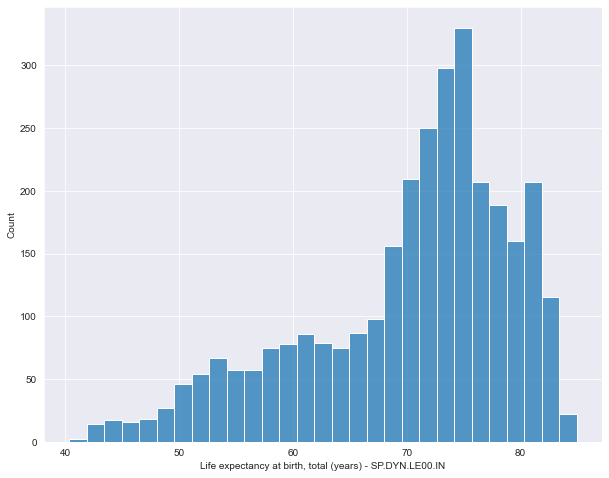

In [5]:
plt.figure(figsize=(10,8))
sns.histplot(data=df['Life expectancy at birth, total (years) - SP.DYN.LE00.IN']);

In [6]:
df['Life expectancy at birth, total (years) - SP.DYN.LE00.IN'].mean()

70.1600975609756

In [7]:
df['High_Life_Expectancy'] = np.where(df['Life expectancy at birth, total (years) - SP.DYN.LE00.IN'] >= 70, 1, 0)
df['High_Life_Expectancy'].value_counts()

High_Life_Expectancy
1    1932
0    1355
Name: count, dtype: int64

### Data Preparation: Removing Null Values
Through quickly looking through the stats above, we can ascertain that this dataset includes several columns with a large amount of null values.  Given this insight, we will be wary of this fact and limit our features to those not missing many null values (so we do not limit our dataset too much, or make later imputations that falsely skew our data).  Below we analyze whether a column is missing under 200 values, and drop nulls if this is the case.  We plan to limit our model to these features; luckily we believe these features will prove to be strong predictors in our model.

In [8]:
df['GDP per capita (current US$) - NY.GDP.PCAP.CD'].isna().value_counts()

GDP per capita (current US$) - NY.GDP.PCAP.CD
False    3246
True       41
Name: count, dtype: int64

In [9]:
df = df[df['GDP per capita (current US$) - NY.GDP.PCAP.CD'].notna()]

In [10]:
df['Access to electricity (% of population) - EG.ELC.ACCS.ZS'].isna().value_counts()

Access to electricity (% of population) - EG.ELC.ACCS.ZS
False    3161
True       85
Name: count, dtype: int64

In [11]:
df = df[df['Access to electricity (% of population) - EG.ELC.ACCS.ZS'].notna()]

In [12]:
df['Adjusted savings: particulate emission damage (% of GNI) - NY.ADJ.DPEM.GN.ZS'].isna().value_counts()

Adjusted savings: particulate emission damage (% of GNI) - NY.ADJ.DPEM.GN.ZS
False    3020
True      141
Name: count, dtype: int64

In [13]:
df = df[df['Adjusted savings: particulate emission damage (% of GNI) - NY.ADJ.DPEM.GN.ZS'].notna()]

In [14]:
# Note, we are interested in visualizing the carbon dioxide and particulate emission damage metrics, but are abstaining
# from including these features in our model as we are hesitant that there is data leakage between these features
df['Adjusted savings: carbon dioxide damage (% of GNI) - NY.ADJ.DCO2.GN.ZS'].isna().value_counts()

Adjusted savings: carbon dioxide damage (% of GNI) - NY.ADJ.DCO2.GN.ZS
False    3008
True       12
Name: count, dtype: int64

In [15]:
df = df[df['Adjusted savings: carbon dioxide damage (% of GNI) - NY.ADJ.DCO2.GN.ZS'].notna()]

In [16]:
df['GDP per capita (current US$) - NY.GDP.PCAP.CD'].isna().value_counts()

GDP per capita (current US$) - NY.GDP.PCAP.CD
False    3008
Name: count, dtype: int64

In [17]:
df = df[df['GDP per capita (current US$) - NY.GDP.PCAP.CD'].notna()]

In [18]:
df['Urban population (% of total population) - SP.URB.TOTL.IN.ZS'].isna().value_counts()

Urban population (% of total population) - SP.URB.TOTL.IN.ZS
False    2865
True      143
Name: count, dtype: int64

In [19]:
df = df[df['Urban population (% of total population) - SP.URB.TOTL.IN.ZS'].notna()]

In [20]:
df['Year'].isna().value_counts()

Year
False    2865
Name: count, dtype: int64

In [21]:
df = df[df['Year'].notna()]

In [22]:
df['Rural population (% of total population) - SP.RUR.TOTL.ZS'].isna().value_counts()

Rural population (% of total population) - SP.RUR.TOTL.ZS
False    2865
Name: count, dtype: int64

In [23]:
df = df[df['Rural population (% of total population) - SP.RUR.TOTL.ZS'].notna()]

In [24]:
df['Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS'].isna().value_counts()

Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS
False    2747
True      118
Name: count, dtype: int64

In [25]:
df = df[df['Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS'].notna()]

In [26]:
df = df[df['Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX'].notna()]

In [27]:
df = df[df['Trade (% of GDP) - NE.TRD.GNFS.ZS'].notna()]

In [28]:
df['High_Life_Expectancy'].value_counts()

High_Life_Expectancy
1    1621
0     998
Name: count, dtype: int64

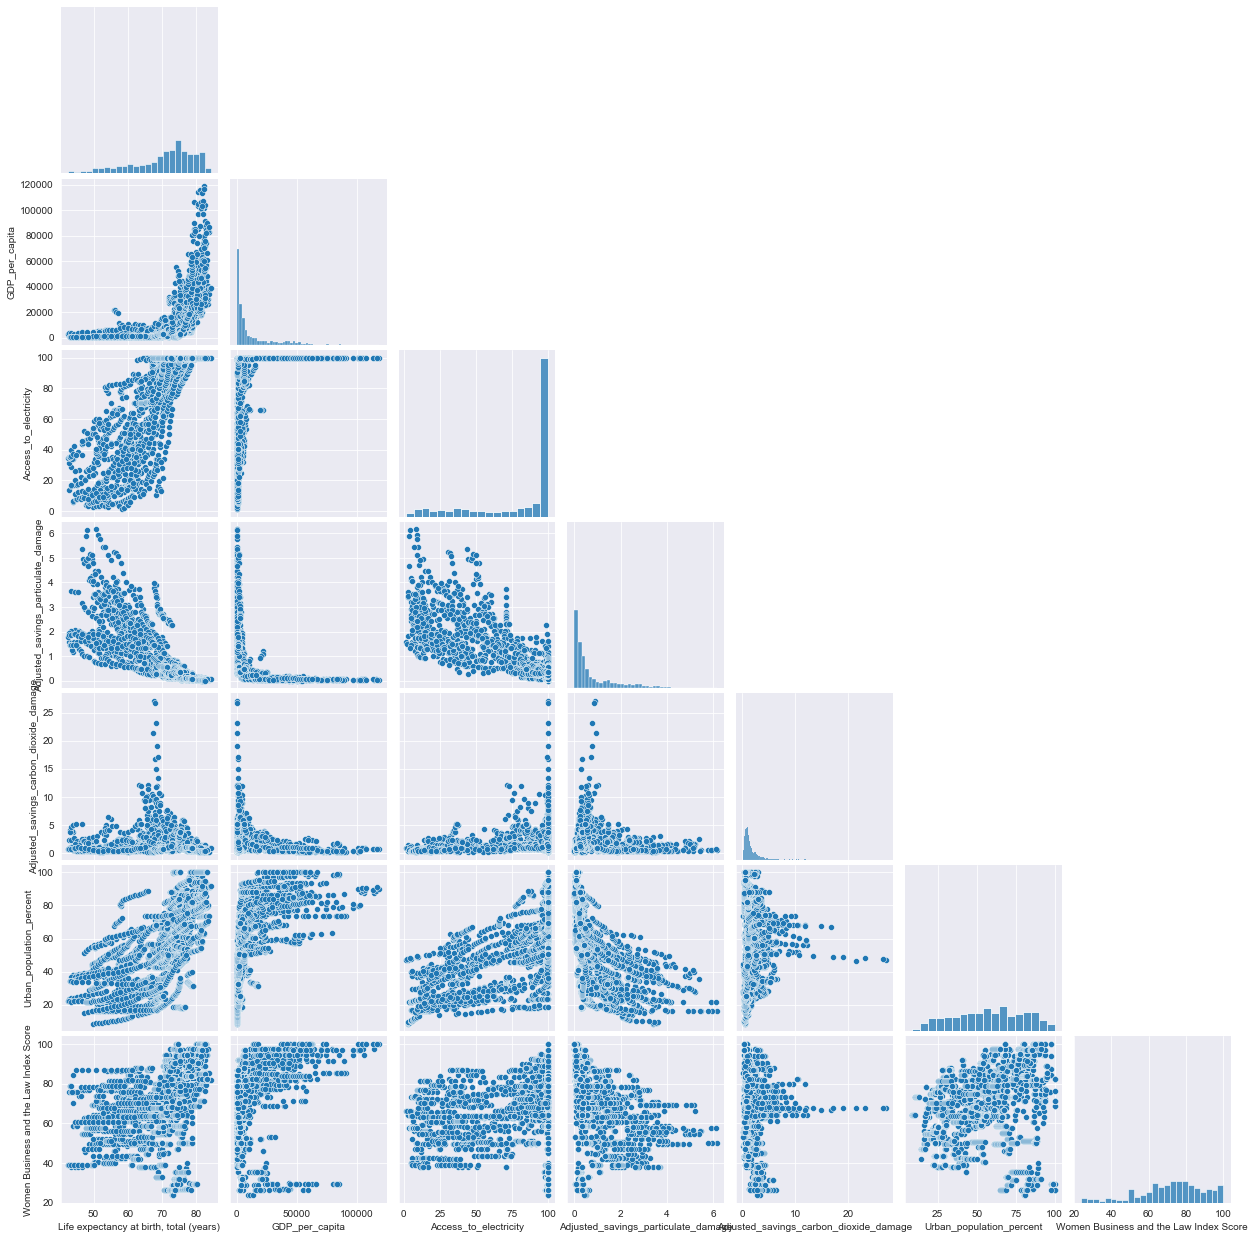

In [29]:
# Renaming Columns Names for Features of Interest to Us
df = df.rename(columns={'Life expectancy at birth, total (years) - SP.DYN.LE00.IN': 'Life expectancy at birth, total (years)',
                    'GDP per capita (current US$) - NY.GDP.PCAP.CD': 'GDP_per_capita', 
                   'Access to electricity (% of population) - EG.ELC.ACCS.ZS': 'Access_to_electricity', 
                   'Adjusted savings: carbon dioxide damage (% of GNI) - NY.ADJ.DCO2.GN.ZS': 'Adjusted_savings_carbon_dioxide_damage',
                   'Urban population (% of total population) - SP.URB.TOTL.IN.ZS': 'Urban_population_percent',
                   'Rural population (% of total population) - SP.RUR.TOTL.ZS': 'Rural_population',
                   'Adjusted savings: particulate emission damage (% of GNI) - NY.ADJ.DPEM.GN.ZS': 'Adjusted_savings_particulate_damage',
                   'Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX': 'Women Business and the Law Index Score'})

# Picking out Columns of Interest to Include
columns_to_include = ['Life expectancy at birth, total (years)', 'GDP_per_capita', 'Access_to_electricity',
                      'Adjusted_savings_particulate_damage', 'Adjusted_savings_carbon_dioxide_damage', 
                      'Urban_population_percent', 'Women Business and the Law Index Score']

# Creating Data Subset from our Main Data Set
data_subset = df[columns_to_include]

# Creating Pairplot
sns.pairplot(data_subset, corner=True);

**Key Takeaways from Pairplot**

We can see that the columns of interest to us, at first glance, seem to show a decent correlation with life expectancy.  More specifically, we believe this visualization tells us that these features will prove to be significant in our model.

### Feature Engineering
There are a few columns within our dataset that include ordinal and categorical data.  Below we are creating dummy columns for these columns so we can include them in our model.  This data is largely geographic, which we believe has a large impact on life expectancy at birth.

In [30]:
dummies = pd.get_dummies(df['Continent'])
df = pd.concat([df, dummies], axis=1)

In [31]:
dummies = pd.get_dummies(df['World Regions (UN SDG Definition)'])
df = pd.concat([df, dummies], axis=1)

In [32]:
dummies = pd.get_dummies(df['Income Classification (World Bank Definition)'])
df = pd.concat([df, dummies], axis=1)

In [33]:
dummies = pd.get_dummies(df['Regime Type (RoW Measure Definition)'])
df = pd.concat([df, dummies], axis=1)
df.head()

,Country Name,Country Code,Year,Access_to_electricity,Adjusted net national income per capita (annual % growth) - NY.ADJ.NNTY.PC.KD.ZG,"Adjusted net savings, excluding particulate emission damage (% of GNI) - NY.ADJ.SVNX.GN.ZS",Adjusted_savings_carbon_dioxide_damage,Adjusted savings: natural resources depletion (% of GNI) - NY.ADJ.DRES.GN.ZS,Adjusted savings: net forest depletion (% of GNI) - NY.ADJ.DFOR.GN.ZS,Adjusted_savings_particulate_damage,...,Oceania,Sub-Saharan Africa,High income,Low income,Lower-middle income,Upper-middle income,Closed Autocracy,Electoral Autocracy,Electoral Democracy,Liberal Democracy
20,Angola,AGO,2001,20.000000,18.457388,-21.156996,2.560090,29.555094,0.0,1.886837,...,False,True,False,True,False,False,True,False,False,False
21,Angola,AGO,2002,26.383869,37.239379,5.021282,1.869649,18.789640,0.0,1.552627,...,False,True,False,True,False,False,True,False,False,False
22,Angola,AGO,2003,27.465635,6.421468,5.148920,1.182633,15.722121,0.0,1.511743,...,False,True,False,True,False,False,True,False,False,False
23,Angola,AGO,2004,28.536760,-8.470402,-1.547946,1.966160,29.984685,0.0,1.426805,...,False,True,False,False,True,False,True,False,False,False
24,Angola,AGO,2005,29.596224,7.704993,1.694223,1.352846,36.249946,0.0,1.238411,...,False,True,False,False,True,False,True,False,False,False


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2619 entries, 20 to 3286
Data columns (total 76 columns):
 #   Column                                                                                        Non-Null Count  Dtype  
---  ------                                                                                        --------------  -----  
 0   Country Name                                                                                  2619 non-null   object 
 1   Country Code                                                                                  2619 non-null   object 
 2   Year                                                                                          2619 non-null   int64  
 3   Access_to_electricity                                                                         2619 non-null   float64
 4   Adjusted net national income per capita (annual % growth) - NY.ADJ.NNTY.PC.KD.ZG              2298 non-null   float64
 5   Adjusted net savings, excluding

### Mapping Out Correlation by Feature
Finally, we are mapping out our features of interest by correlation to Life Expectancy at Birth.  Note, this visualization includes the correlation between columns with discrete data as our boolean columns may not provide the most insight here.  From the below visualization, we see that 'GDP Per Capita', 'Urban Population', and 'Access to Electricity' are the features that are the most correlated to Life Expectancy at Birth.

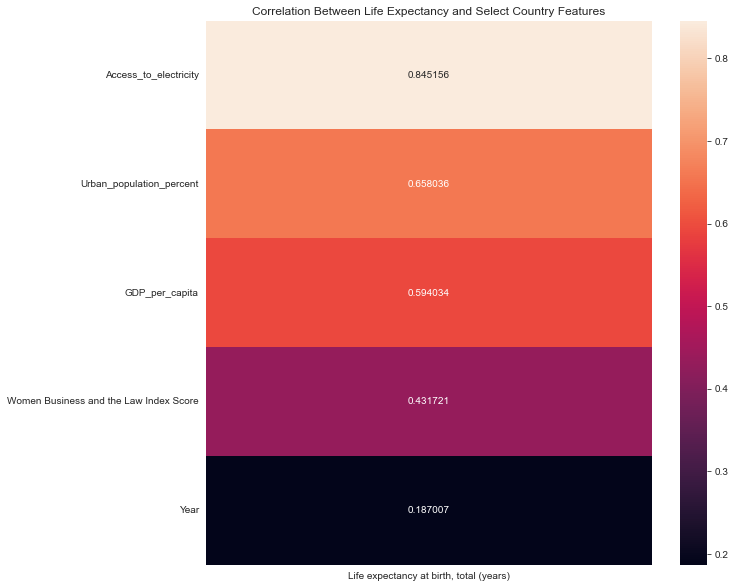

In [35]:
col_list = [df['GDP_per_capita'], df['Access_to_electricity'], df['Women Business and the Law Index Score'],
          df['Urban_population_percent'], df['Year']]

corr_df = df[['GDP_per_capita', 'Access_to_electricity', 'Women Business and the Law Index Score', 
              'Urban_population_percent', 'Year']]

corr_list = []
col_names = []

for col in col_list:
    corr_list.append(df['Life expectancy at birth, total (years)'].corr(col))

for col in corr_df.columns:
    col_names.append(col)

df_heat = pd.DataFrame({"Life expectancy at birth, total (years)": corr_list}, index=col_names)

df_heat = df_heat.sort_values(by=['Life expectancy at birth, total (years)'], ascending=False)

plt.figure(figsize=(10,10))
sns.heatmap(df_heat, annot=True, fmt="g").set(Title="Correlation Between Life Expectancy and Select Country Features")

plt.show()

### Visualizing the Geographic Spread of Our Features
Below we create visualizations that speak to the geographic spread of the features we are including in our model.  As many of these features pertain to country geographies (e.g. Continent- and Region-focused variables), we were interested in visualizing this spread.

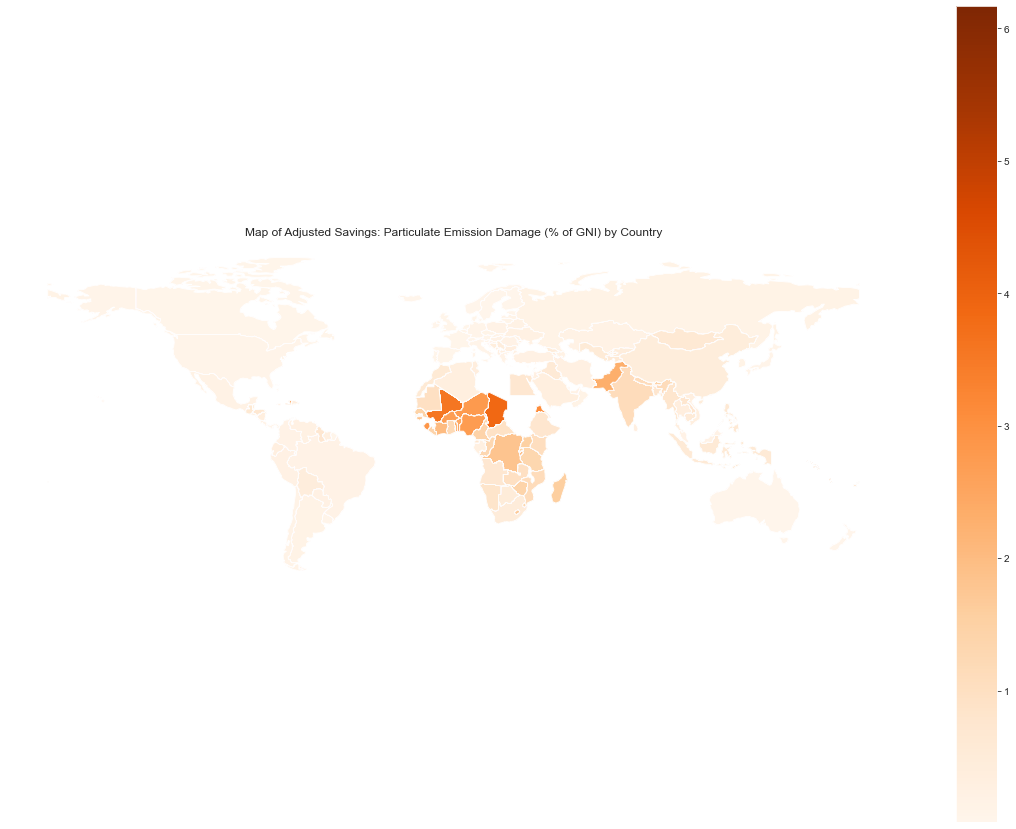

In [36]:
# Load the world shapefile data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world shapefile with your dataset based on the country code
merged = world.merge(df, left_on='iso_a3', right_on='Country Code', how = 'left' )

# Select the feature column you want to visualize
feature_column = 'Adjusted_savings_particulate_damage'

# Plot the choropleth map
fig, ax = plt.subplots(figsize=(20, 15))
merged.plot(column=feature_column, cmap='Oranges', linewidth=0.8, ax=ax, edgecolor='white', legend=True)
ax.set_title('Map of Adjusted Savings: Particulate Emission Damage (% of GNI) by Country')
ax.axis('off')
plt.show();

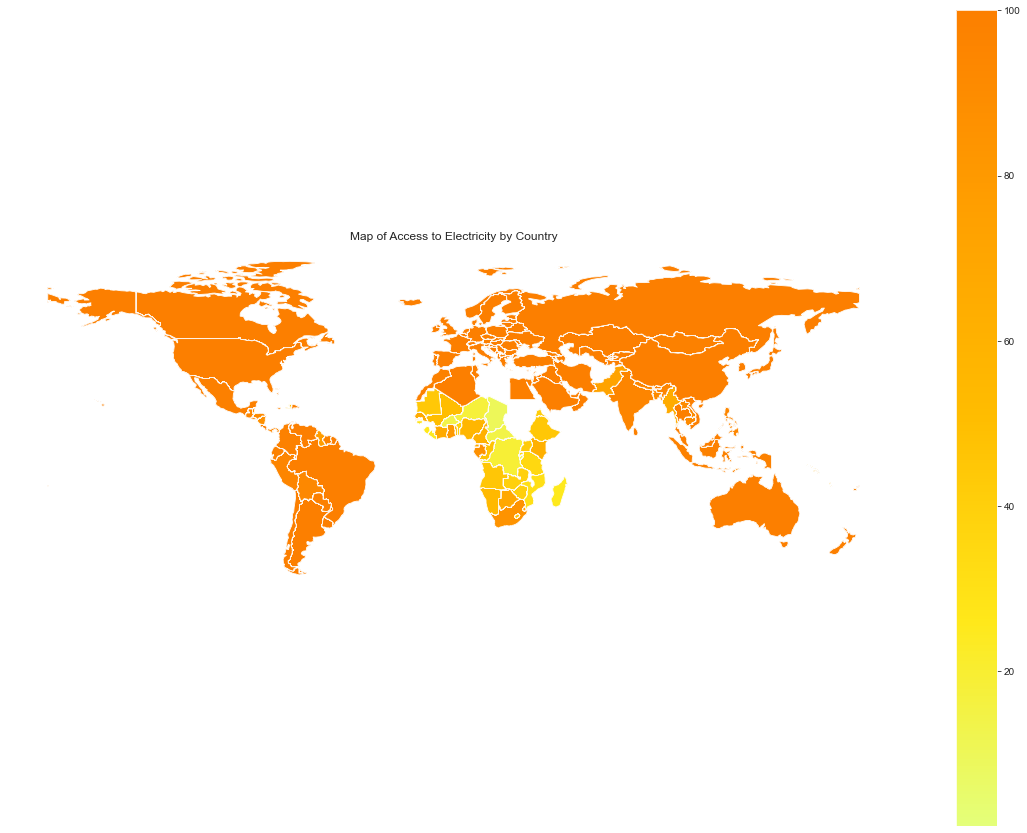

In [37]:
# Load the world shapefile data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world shapefile with your dataset based on the country code
merged = world.merge(df, left_on='iso_a3', right_on='Country Code', how = 'left' )

# Select the feature column you want to visualize
feature_column = 'Access_to_electricity'

# Plot the choropleth map
fig, ax = plt.subplots(figsize=(20, 15))
merged.plot(column=feature_column, cmap='Wistia', linewidth=.8, ax=ax, edgecolor='white', legend=True)
ax.set_title('Map of Access to Electricity by Country')
ax.axis('off')
plt.show()

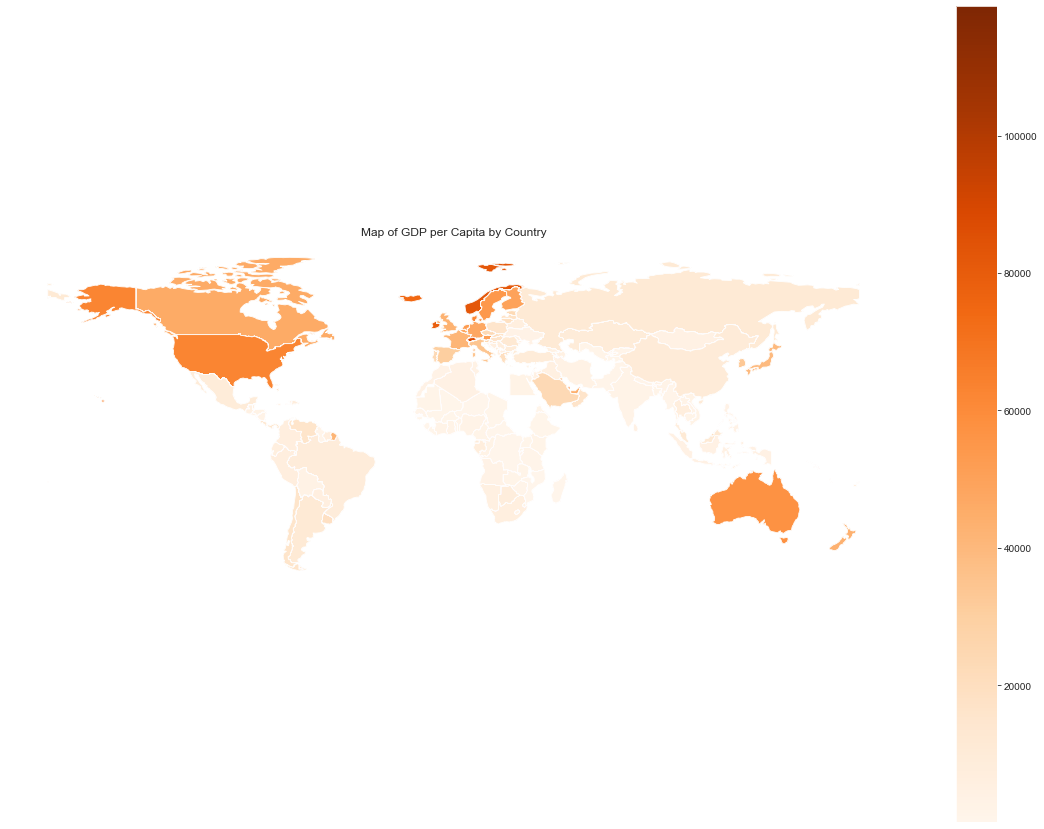

In [38]:
# Load the world shapefile data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world shapefile with your dataset based on the country code
merged = world.merge(df, left_on='iso_a3', right_on='Country Code', how = 'left' )

# Select the feature column you want to visualize
feature_column = 'GDP_per_capita'

# Plot the choropleth map
fig, ax = plt.subplots(figsize=(20, 15))
merged.plot(column=feature_column, cmap='Oranges', linewidth=0.8, ax=ax, edgecolor='white', legend=True)
ax.set_title('Map of GDP per Capita by Country')
ax.axis('off')
plt.show()

### Visualizing Model Features
The following visualizations show the relationship between life expectancy and select features we plan to use in our model (outside of the particulate damage feature).  We've set the hue of each data point to be consistent for each country, so we can analyse the change in relationship between life expectancy and our features over time.

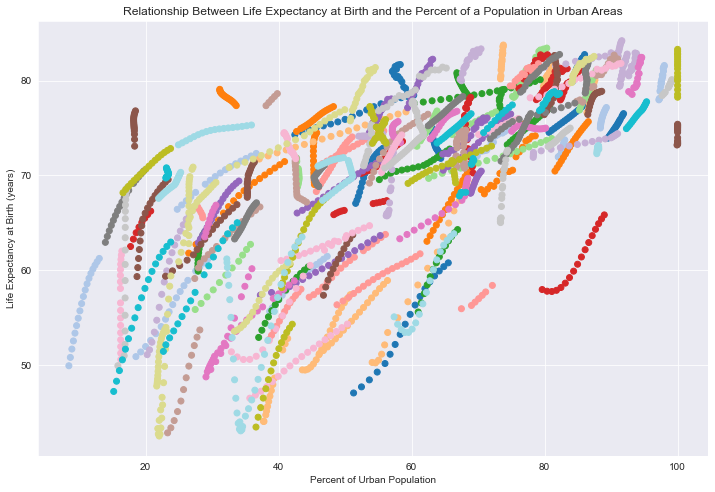

In [39]:
plt.figure(figsize=(12,8))

# Create a unique color for each country
countries = df['Country Name'].unique()
num_countries = len(countries)
color_map = plt.get_cmap('tab20')
colors = color_map(np.linspace(0, 1, num_countries))

# Assign a color to each country
country_colors = {country: color for country, color in zip(countries, colors)}

# Map the country names to their respective colors
df['Color'] = df['Country Name'].map(country_colors)

# Create the scatter plot
plt.scatter(df['Urban_population_percent'], df['Life expectancy at birth, total (years)'],
            c=df['Color'])

# Add labels and a colorbar
plt.title("Relationship Between Life Expectancy at Birth and the Percent of a Population in Urban Areas")
plt.xlabel('Percent of Urban Population')
plt.ylabel('Life Expectancy at Birth (years)')

# Show the plot
plt.show()

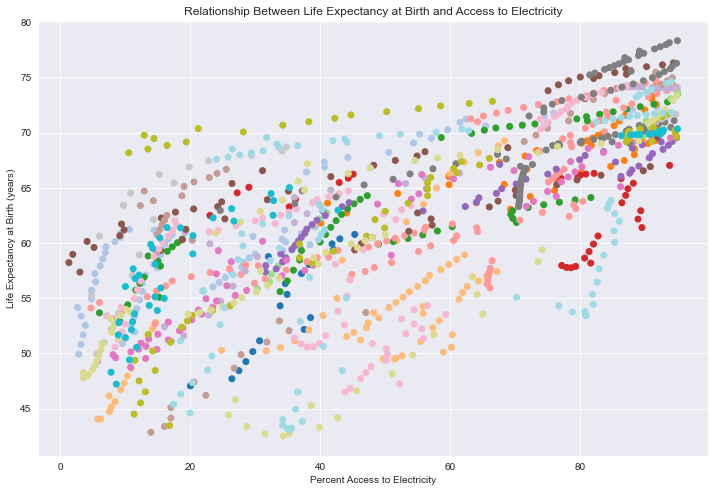

In [40]:
# Creating column that doesn't include countries with over 95% access to electricity
# This will clean up the visualization
threshold = 95
mask = df['Access_to_electricity'] < threshold
df['dev_countries_elec_access'] = df.loc[mask, 'Access_to_electricity']

# Setting the Plot
plt.figure(figsize=(12,8))

# Create a unique color for each country
countries = df['Country Name'].unique()
num_countries = len(countries)
color_map = plt.get_cmap('tab20')
colors = color_map(np.linspace(0, 1, num_countries))

# Assign a color to each country
country_colors = {country: color for country, color in zip(countries, colors)}

# Map the country names to their respective colors
df['Color'] = df['Country Name'].map(country_colors)

# Create the scatter plot
plt.scatter(df['dev_countries_elec_access'], df['Life expectancy at birth, total (years)'],
            c=df['Color'])

# Add labels and a colorbar
plt.title("Relationship Between Life Expectancy at Birth and Access to Electricity")
plt.xlabel('Percent Access to Electricity')
plt.ylabel('Life Expectancy at Birth (years)')

# Show the plot
plt.show()

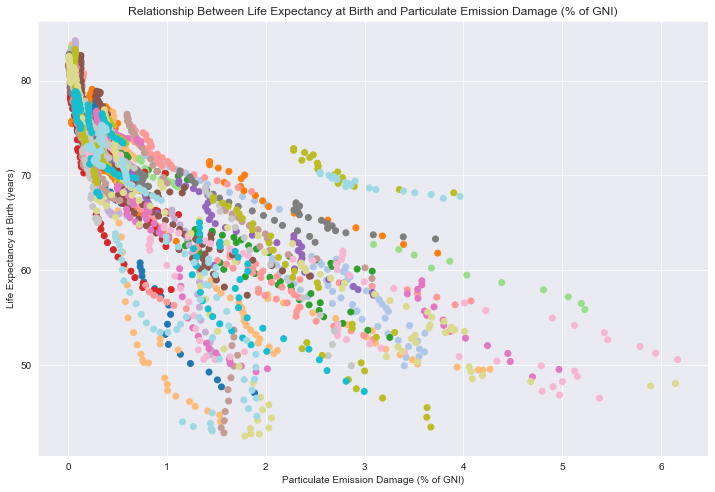

In [41]:
# Setting the Plot
plt.figure(figsize=(12,8))

# Create a unique color for each country
countries = df['Country Name'].unique()
num_countries = len(countries)
color_map = plt.get_cmap('tab20')
colors = color_map(np.linspace(0, 1, num_countries))

# Assign a color to each country
country_colors = {country: color for country, color in zip(countries, colors)}

# Map the country names to their respective colors
df['Color'] = df['Country Name'].map(country_colors)

# Create the scatter plot
plt.scatter(df['Adjusted_savings_particulate_damage'], df['Life expectancy at birth, total (years)'],
            c=df['Color'])

# Add labels and a colorbar
plt.title("Relationship Between Life Expectancy at Birth and Particulate Emission Damage (% of GNI)")
plt.xlabel('Particulate Emission Damage (% of GNI)')
plt.ylabel('Life Expectancy at Birth (years)')

# Show the plot
plt.show()

### Saving our Cleaned Data to .CSV for Modeling

In [42]:
df.to_csv('data/cleaned_international_data.csv')